In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# videos that match 2300 hashtags
dat = pd.read_csv("../data/2300match_with_dates.csv")

In [2]:
dat.columns

Index(['uniqueID', 'Video ID', 'Video URL', 'hashtags', 'collectCount',
       'commentCount', 'diggCount', 'playCount', 'shareCount', 'file_path',
       'matching_hashtags', 'num_matching_hashtags',
       'caseless_matching_hashtags', 'new_matching_hashtags',
       'matching_hashtags_length', 'new_matching_hashtags_length',
       'readable_date', 'createTime'],
      dtype='object')

In [3]:
dat["createTime"].head()

0    1.695916e+09
1    1.697630e+09
2    1.701273e+09
3    1.676467e+09
4    1.622899e+09
Name: createTime, dtype: float64

In [2]:
# clean dates
dat['upload_time'] = pd.to_datetime(dat['createTime'], unit='s',errors='coerce')

# Check for invalid dates
invalid_dates = dat['upload_time'].isna().sum()
if invalid_dates > 0:
    print(f"Number of invalid dates: {invalid_dates}")
    dat = dat.dropna(subset=['upload_time'])

Number of invalid dates: 646


In [5]:
dat["upload_time"].head()

0   2023-09-28 15:39:44
1   2023-10-18 11:58:36
2   2023-11-29 15:48:43
3   2023-02-15 13:18:32
4   2021-06-05 13:14:06
Name: upload_time, dtype: datetime64[ns]

In [3]:
key_hashtags = ['addiction', 'recovery', 'harmreduction', 
                 'harmreductionsaveslives', 'wedorecover',
                 'pinger', 'opioids', 'fent', 'pingtok', 'narcansaveslives']

In [4]:
def analyze_engagement(df):
    # Calculate basic statistics for engagement metrics
    metrics = ['collectCount', 'commentCount', 'diggCount', 'playCount', 'shareCount']
    
    print("Overall engagement statistics:")
    print(df[metrics].describe())
    
    # Calculate median engagement rates to handle skewed distributions
    medians = df[metrics].median()
    return medians

In [5]:
def analyze_key_hashtags(df):
    
    hashtag_stats = {}
    
    for tag in key_hashtags:
        # Filter videos containing each key hashtag
        mask = df['hashtags'].str.contains(tag, case=False, na=False)
        videos_with_tag = df[mask]
        
        hashtag_stats[tag] = {
            'video_count': len(videos_with_tag),
            'mean_plays': videos_with_tag['playCount'].mean(),
            'median_plays': videos_with_tag['playCount'].median(),
            'mean_likes': videos_with_tag['diggCount'].mean(),
            'median_likes': videos_with_tag['diggCount'].median(),
            'mean_shares': videos_with_tag['shareCount'].mean(),
            'mean_comments': videos_with_tag['commentCount'].mean()
        }
    
    return pd.DataFrame(hashtag_stats).T

In [6]:
def analyze_temporal_patterns(df):
    # Convert createTime to datetime if needed
    # df['datetime'] = pd.to_datetime(df['createTime'], unit='s')
    df['month_year'] = df['upload_time'].dt.to_period('M')
    
    # Monthly video counts
    monthly_counts = df.groupby('month_year').size()
    
    # Monthly engagement
    monthly_engagement = df.groupby('month_year').agg({
        'playCount': 'mean',
        'diggCount': 'mean',
        'commentCount': 'mean',
        'shareCount': 'mean'
    })
    
    return monthly_counts, monthly_engagement


In [7]:
def plot_engagement_metrics(hashtag_stats):
    metrics = ['median_plays', 'median_likes', 'mean_comments', 'mean_shares']
    titles = ['Median Views', 'Median Likes', 'Mean Comments', 'Mean Shares']
    
    # Create subplots - 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Plot each metric
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        sns.barplot(data=hashtag_stats.reset_index(), 
                   x='index', y=metric, ax=axes[i])
        axes[i].set_title(f'{title} by Key Hashtag', fontsize=12)
        axes[i].set_xlabel('Hashtag', fontsize=10)
        axes[i].set_ylabel(title, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# def plot_engagement_by_hashtag(hashtag_stats):
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=hashtag_stats.reset_index(), 
#                 x='index', y='median_plays')
#     plt.xticks(rotation=45)
#     plt.title('Median Views by Key Hashtag')
#     plt.tight_layout()
#     plt.show()

def plot_temporal_trends(monthly_counts, window=3):
    plt.figure(figsize=(12, 6))
    
    # Calculate rolling average
    rolling_avg = monthly_counts.rolling(window=window, center=True).mean()
    
    # Plot rolling average
    plt.plot(range(len(rolling_avg)), rolling_avg, 
            linewidth=2, label='3-month rolling average')
    
    plt.title('Number of Videos Posted Over Time\n(3-month rolling average)')
    plt.xlabel('Months (Chronologically from Earliest to Latest)')
    plt.ylabel('Number of Videos')
    
    # Get x-axis labels
    month_labels = monthly_counts.index
    plt.xticks(range(len(month_labels)), 
               [str(date) for date in month_labels],
               rotation=45)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_hashtag_trends(monthly_counts_by_hashtag, window=3):
    plt.figure(figsize=(15, 8))
    
    # Plot rolling average for each hashtag
    for hashtag, monthly_counts in monthly_counts_by_hashtag.items():
        # Calculate rolling average
        rolling_avg = monthly_counts.rolling(window=window, center=True).mean()
        
        # Plot rolling average
        plt.plot(monthly_counts.index.astype(str), rolling_avg,
                label=hashtag,
                linewidth=2)
    
    # Customize plot
    plt.title('Temporal Trends of Key Substance Use Related Hashtags on TikTok\n(with 3-month rolling average)', 
             fontsize=14, pad=20)
    plt.xlabel('Months (Chronologically from Earliest to Latest)', fontsize=12)
    plt.ylabel('Number of Videos', fontsize=12)
    plt.legend(title='Hashtags', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [8]:
def get_monthly_counts_by_hashtag(df, hashtags):
    # Convert time and group by month
    # df['datetime'] = pd.to_datetime(df['createTime'], unit='s')
    df['month_year'] = df['upload_time'].dt.to_period('M')
    
    monthly_counts = {}
    for hashtag in hashtags:
        mask = df['hashtags'].str.contains(hashtag, case=False, na=False)
        videos_with_tag = df[mask]
        
        monthly_counts[hashtag] = (videos_with_tag.groupby('month_year')
                                 .size()
                                 .sort_index())
    
    return monthly_counts

def main_analysis(df):
    print("Dataset Overview:")
    print(f"Total number of videos: {len(df)}")
    
    # Run analyses
    medians = analyze_engagement(df)
    hashtag_stats = analyze_key_hashtags(df)
    monthly_counts, monthly_engagement = analyze_temporal_patterns(df)
    
    monthly_counts_by_hashtag = get_monthly_counts_by_hashtag(df, key_hashtags)

    # Create visualizations
    plot_engagement_metrics(hashtag_stats)
    plot_temporal_trends(monthly_counts)
    plot_hashtag_trends(monthly_counts_by_hashtag)
    
    # Print key findings
    print("\nKey Hashtag Statistics:")
    print(hashtag_stats)
    return {
        'medians': medians,
        'hashtag_stats': hashtag_stats,
        'monthly_counts': monthly_counts,
        'monthly_engagement': monthly_engagement
    }

Dataset Overview:
Total number of videos: 38863
Overall engagement statistics:
       collectCount   commentCount     diggCount     playCount    shareCount
count  3.886300e+04   38863.000000  3.886300e+04  3.886300e+04  3.886300e+04
mean   4.811242e+03     708.095541  6.707470e+04  6.857778e+05  3.546762e+03
std    2.547998e+04    3825.981114  3.259807e+05  3.205633e+06  2.499889e+04
min    0.000000e+00       0.000000  0.000000e+00  0.000000e+00  0.000000e+00
25%    6.000000e+00       9.000000  2.040000e+02  2.976500e+03  3.000000e+00
50%    7.300000e+01      52.000000  1.925000e+03  2.900000e+04  3.100000e+01
75%    1.291000e+03     292.000000  2.780000e+04  2.943000e+05  4.870000e+02
max    2.000000e+06  407200.000000  2.440000e+07  2.216000e+08  1.800000e+06


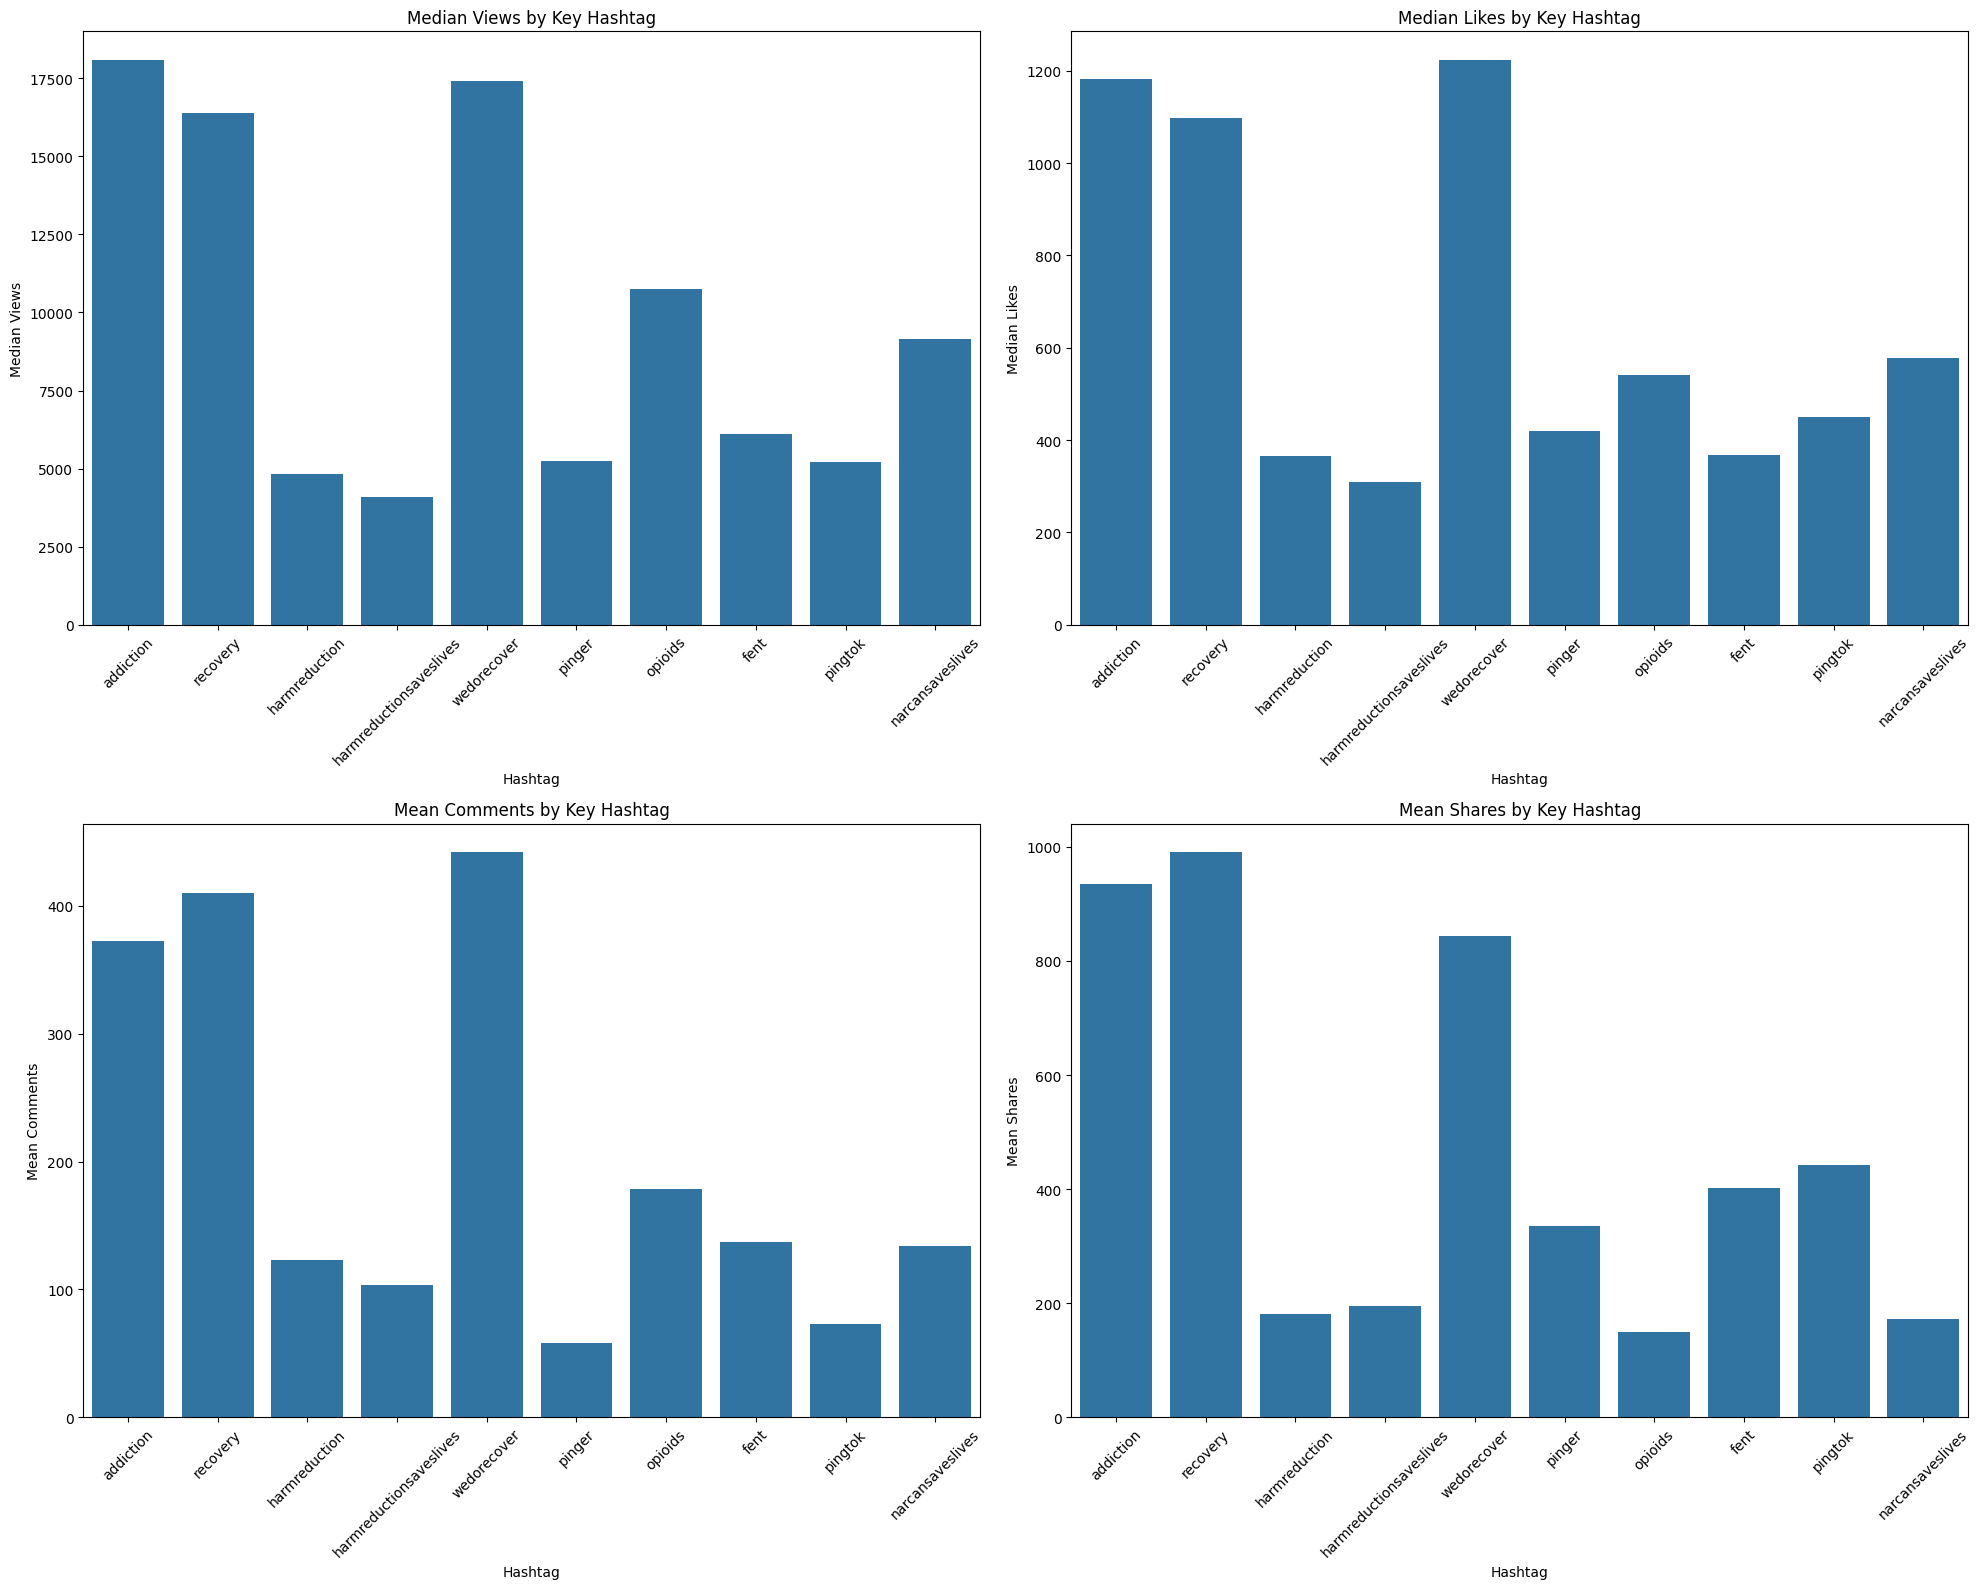

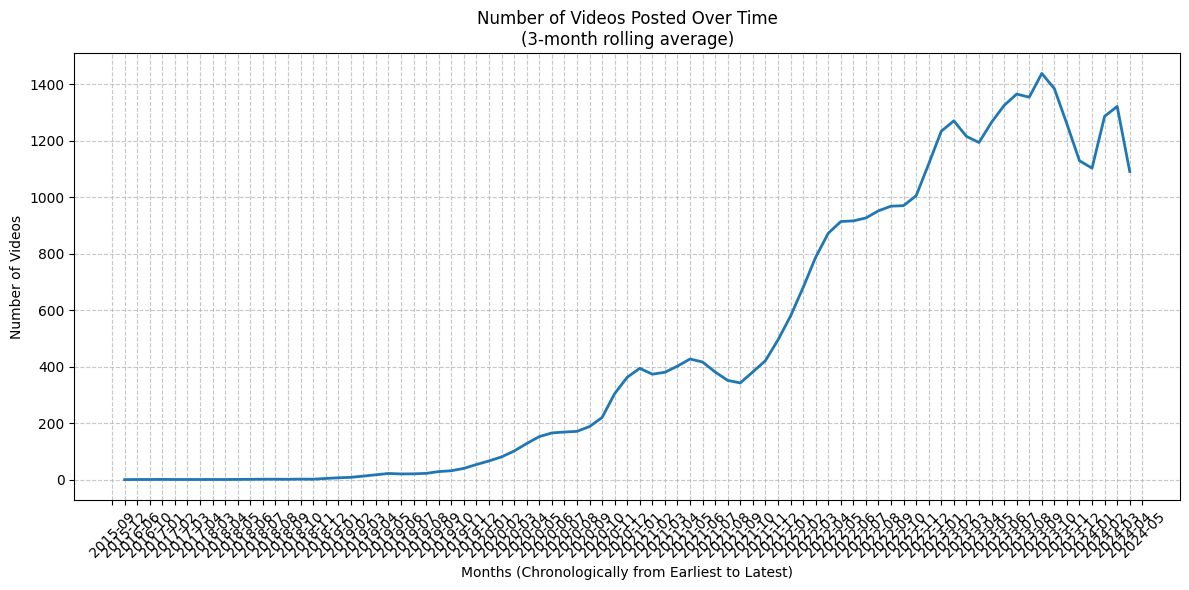

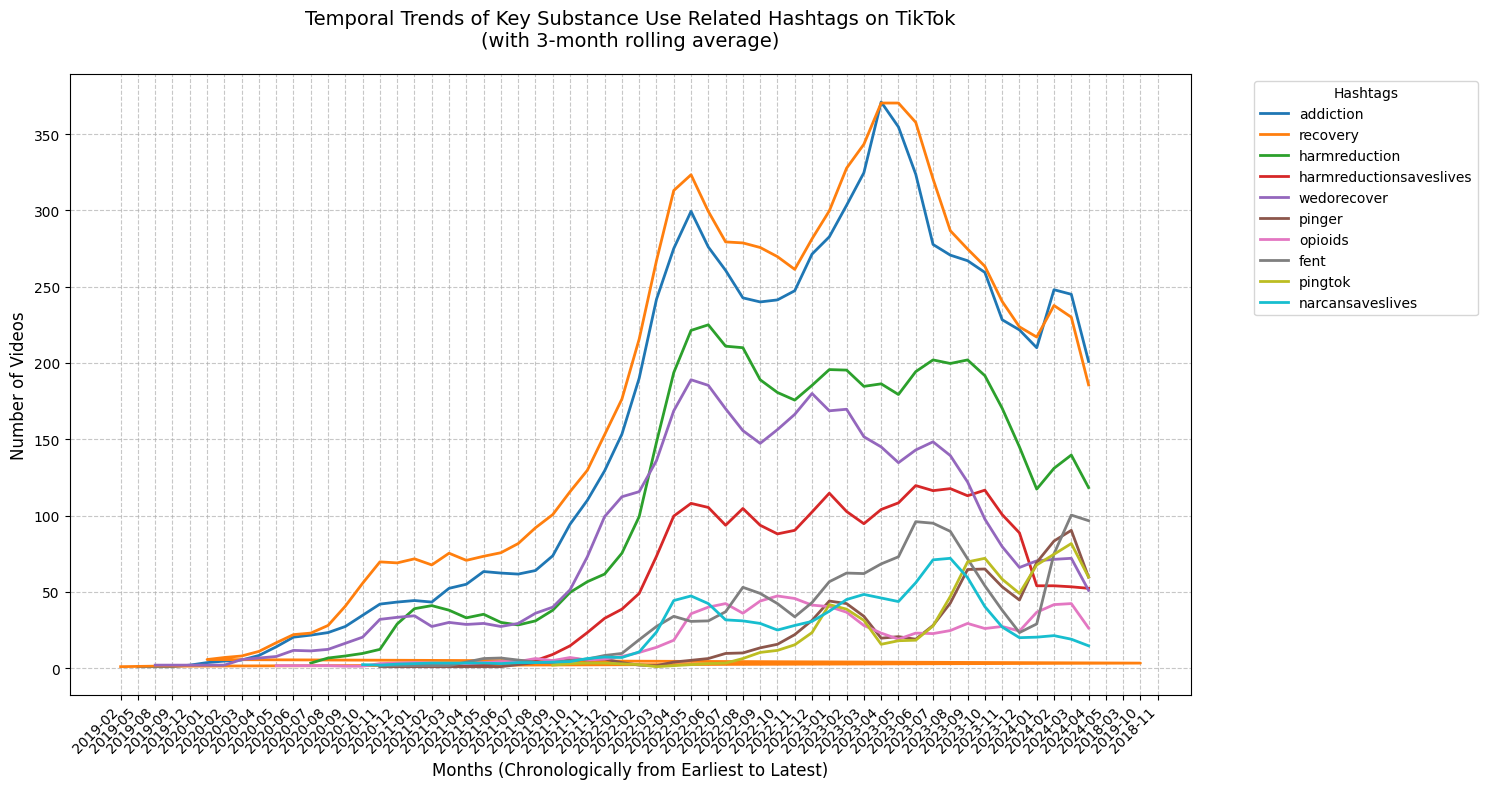


Key Hashtag Statistics:
                         video_count     mean_plays  median_plays  \
addiction                     8571.0  286490.095788       18100.0   
recovery                      9395.0  298153.984141       16400.0   
harmreduction                 5505.0   66312.053406        4832.0   
harmreductionsaveslives       2704.0   73991.190828        4074.0   
wedorecover                   4414.0  288152.185773       17400.0   
pinger                         972.0   44927.564815        5243.0   
opioids                        930.0   57458.081720       10750.0   
fent                          1617.0   77552.544836        6100.0   
pingtok                        919.0   61930.475517        5214.0   
narcansaveslives              1063.0   76259.896519        9146.0   

                           mean_likes  median_likes  mean_shares  \
addiction                25454.136740        1183.0   935.782872   
recovery                 26095.374135        1097.0   990.957743   
harmreducti

In [9]:
results = main_analysis(dat)

In [10]:
print(dat['upload_time'].describe())
print(dat['month_year'].value_counts().sort_index())

count                            38863
mean     2022-11-25 15:06:01.132105216
min                2015-09-22 16:58:03
25%                2022-04-16 23:21:37
50%                2023-02-07 00:08:24
75%                2023-09-23 02:56:38
max                2024-05-13 20:58:38
Name: upload_time, dtype: object
month_year
2015-09       1
2015-12       1
2016-06       1
2016-10       2
2017-01       1
           ... 
2024-01    1175
2024-02    1138
2024-03    1546
2024-04    1280
2024-05     447
Freq: M, Name: count, Length: 83, dtype: int64


---
# Coded Videos

In [11]:
coded = pd.read_csv("../data/coded_videos_V2.csv")
community = pd.read_csv("../data/k10node_list_with_weights.csv")

In [ ]:
# print(coded['upload_time'].describe())

In [13]:
coded["Video Topic?"].value_counts()

Video Topic?
Recovery Advocacy                        119
Satirical and relatable content           99
Informational Content                     46
Other                                     45
Promotional Content                       24
Documentation of use for social media     14
Trip Reports                               4
Name: count, dtype: int64

In [14]:
# join in date information
coded = coded.rename(columns={'Unnamed: 1': 'Video ID'})
coded = coded.merge(
    dat[['Video ID', 'createTime']],
    on = 'Video ID',
    how= "left"
)

In [15]:
# joing community info
def match_themes(hashtag_list, theme_map):
   themes = []
   for hashtag in hashtag_list:
       if hashtag in theme_map:
           themes.append(theme_map[hashtag])
   return themes if themes else None

coded['hashtags'] = coded['hashtags'].apply(lambda x: eval(x) if isinstance(x, str) else x)
theme_dict = dict(zip(community['Node'], community['Community']))
coded['themes'] = coded['hashtags'].apply(lambda x: match_themes(x, theme_dict))


In [16]:
flat_themes = []
for themes in coded['themes']:
   if themes:  # Check if not None
       flat_themes.extend(list(set(themes)))  # Add unique themes only

# Get distribution
theme_dist = pd.Series(flat_themes).value_counts()

# Optional: Convert to dataframe and calculate percentages
theme_dist_df = pd.DataFrame({
   'count': theme_dist,
   'percentage': theme_dist / len(coded) * 100
})

print(theme_dist_df)

                             count  percentage
platform                       203   57.834758
health_conditions              180   51.282051
awareness_and_advocacy         176   50.142450
misc                           126   35.897436
commonly_misused_substances    111   31.623932
consumption_method             101   28.774929
emotions_and_feelings          100   28.490028
identity_and_community          95   27.065527
humor                           76   21.652422
other_substances                67   19.088319
substance_effects               66   18.803419
tobacco_nicotine                60   17.094017
location                        60   17.094017
alcohol                         59   16.809117
occupation                      53   15.099715
cannabis                        37   10.541311
cognitive_enhancement           26    7.407407


### number of hashtags per community and per topic

In [40]:
# Explode the 'themes' column to get one row per hashtag
exploded_coded = coded.explode('themes')

# Group by 'themes' and 'Video Topic?', count occurrences
community_dist = exploded_coded.groupby(['themes', 'Video Topic?']).size().unstack(fill_value=0)

# Add a 'Total' column for overall distribution
community_dist['Total'] = community_dist.sum(axis=1)

# Calculate percentages for each topic
community_dist_percentage = community_dist.div(community_dist['Total'], axis=0) * 100

# Format as 'N (%)'
formatted_table = community_dist.iloc[:, :-1].apply(  # Exclude the 'Total' column
    lambda row: [f"{int(n)} ({p:.1f}%)" for n, p in zip(row, community_dist_percentage.loc[row.name])],
    axis=1
)

# Convert the result to a DataFrame for display
formatted_table = pd.DataFrame(formatted_table.tolist(), 
                                index=community_dist.index, 
                                columns=community_dist.columns[:-1])  # Exclude 'Total'

# Add the 'Total' column back
formatted_table['Total'] = community_dist['Total']

In [41]:
formatted_table.to_csv("../data/community_by_topic.csv")

### number of videos per hashtag community per topic

In [47]:
# Initialize a list to store video-community-topic mappings
video_topic_community = []

# Loop through each row in the dataset
for idx, row in coded.iterrows():
    if row['themes']:  # Check if there are themes for this video
        unique_themes = list(set(row['themes']))  # Get unique themes
        for theme in unique_themes:
            video_topic_community.append({
                'video_id': row['Video ID'],  # Assuming a unique identifier exists
                'Video Topic?': row['Video Topic?'],  # Get the topic
                'community': theme  # Get the theme (community)
            })

# Convert the list into a DataFrame
community_topic_df = pd.DataFrame(video_topic_community)

# Count unique video IDs for each (community, topic) pair
community_topic_dist = community_topic_df.groupby(['community', 'Video Topic?'])['video_id'].nunique().unstack(fill_value=0)

# Add a total column for each community
community_topic_dist['Total'] = community_topic_dist.sum(axis=1)

# Calculate percentages for each topic
community_topic_percentage = community_topic_dist.div(community_topic_dist['Total'], axis=0) * 100

# Format as a table with 'N (%)' values
formatted_table = community_topic_dist.iloc[:, :-1].apply(
    lambda row: [f"{int(n)} ({p:.1f}%)" for n, p in zip(row, community_topic_percentage.loc[row.name])],
    axis=1
)

# Convert back to a DataFrame for better presentation
formatted_table = pd.DataFrame(
    formatted_table.tolist(), 
    index=community_topic_dist.index, 
    columns=community_topic_dist.columns[:-1]  # Exclude 'Total' column
)

# Add the Total column (only counts, no percentages)
formatted_table['Total'] = community_topic_dist['Total']

In [48]:
formatted_table.to_csv("../data/community_by_topic_nvideos.csv")

In [17]:
# get this dist for the full 39k
def match_themes(hashtag_list, theme_map):
   themes = []
   for hashtag in hashtag_list:
       if hashtag in theme_map:
           themes.append(theme_map[hashtag])
   return themes if themes else None

dat['hashtags'] = dat['hashtags'].apply(lambda x: eval(x) if isinstance(x, str) else x)
dat['themes'] = dat['hashtags'].apply(lambda x: match_themes(x, theme_dict))

flat_themes_full = []
for themes in dat['themes']:
   if themes:  # Check if not None
       flat_themes_full.extend(list(set(themes)))  # Add unique themes only

# Get distribution
theme_dist_full = pd.Series(flat_themes_full).value_counts()

# Optional: Convert to dataframe and calculate percentages
theme_dist_full_df = pd.DataFrame({
   'count': theme_dist_full,
   'percentage': theme_dist_full / len(dat) * 100
})

print(theme_dist_full_df)

                             count  percentage
platform                     22704   58.420606
misc                         17063   43.905514
health_conditions            16350   42.070864
awareness_and_advocacy       15949   41.039035
commonly_misused_substances  10755   27.674137
emotions_and_feelings         9404   24.197823
identity_and_community        8093   20.824435
other_substances              7627   19.625351
humor                         5957   15.328204
location                      5315   13.676247
consumption_method            4788   12.320202
cannabis                      3322    8.547976
substance_effects             3267    8.406453
alcohol                       3218    8.280370
occupation                    2869    7.382343
tobacco_nicotine              2433    6.260453
cognitive_enhancement         1751    4.505571


In [18]:
# compare
import scipy.stats as stats
n_coded = len(coded)  # e.g., if coded has 350 videos 
n_full = len(dat)

coded_counts = theme_dist_df['count']
full_counts = theme_dist_full_df['count']

chi2,p_value = stats.chi2_contingency([
    coded_counts,
    full_counts
])[:2]
print(f"Overall Chi-square test: chi2={chi2:.2f}, p={p_value:.4f}")

Overall Chi-square test: chi2=94.78, p=0.0000


In [19]:
z_scores = []
p_values = []
categories = theme_dist_df.index
for cat in categories:
       p1 = theme_dist_df.loc[cat, 'percentage'] / 100  
       p2 = theme_dist_full_df.loc[cat, 'percentage'] / 100
       
       # Pooled standard error
       se = np.sqrt(p1*(1-p1)/n_coded + p2*(1-p2)/n_full)
       
       # Z-score
       z = (p1 - p2) / se
       p = 2 * (1 - stats.norm.cdf(abs(z)))
       
       z_scores.append(z)
       p_values.append(p)
results_df = pd.DataFrame({
    'z_score': z_scores,
    'p_value': p_values
}, index=categories)
print("\nCategory-wise comparisons:")
results_df


Category-wise comparisons:


,z_score,p_value
platform,-0.221270,8.248825e-01
health_conditions,3.437456,5.872054e-04
awareness_and_advocacy,3.396250,6.831584e-04
misc,-3.112601,1.854465e-03
commonly_misused_substances,1.584748,1.130236e-01
consumption_method,6.793435,1.094946e-11
emotions_and_feelings,1.774376,7.600093e-02
identity_and_community,2.621848,8.745435e-03
humor,2.866811,4.146308e-03
other_substances,-0.254841,7.988456e-01


---
## Compare videos with substance shown vs not

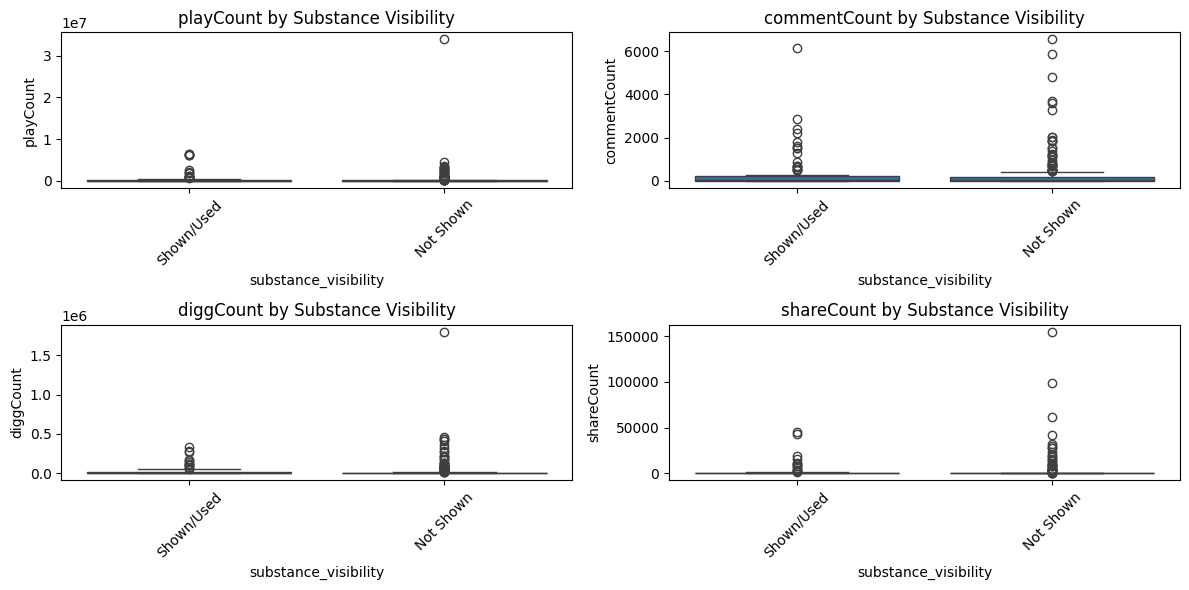

<Figure size 1000x600 with 0 Axes>

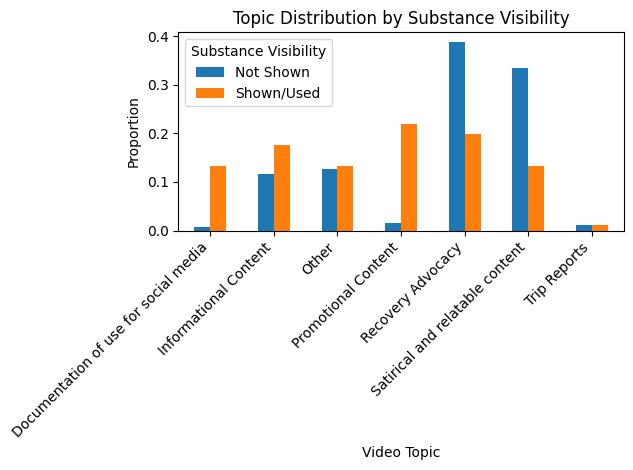


Statistical Test Results (Mann-Whitney U):

playCount:
Statistic: 13021.00
P-value: 0.1530

commentCount:
Statistic: 11867.50
P-value: 0.9646

diggCount:
Statistic: 12355.00
P-value: 0.5290

shareCount:
Statistic: 12813.50
P-value: 0.2368

Mean Engagement Metrics by Group:
                          playCount               commentCount              \
                               mean           std         mean         std   
substance_visibility                                                         
Not Shown             380494.542308  2.189844e+06   291.892308  789.190610   
Shown/Used            577684.076923  1.451418e+06   342.659341  832.722619   

                         diggCount                  shareCount                
                              mean            std         mean           std  
substance_visibility                                                          
Not Shown             31872.565385  131599.909125  2810.123077  12980.052454  
Shown/Used        

In [20]:
from scipy import stats
# Create substance visibility groups
# Combine "Showing" and "Using" into one group vs "Not shown"
coded['substance_visibility'] = coded['Are drugs/substance shown?'].map(
    lambda x: 'Shown/Used' if x in ['Showing', 'Using'] else 'Not Shown'
)

# Function to perform statistical testing
def compare_engagement(df, metric):
    shown = df[df['substance_visibility'] == 'Shown/Used'][metric]
    not_shown = df[df['substance_visibility'] == 'Not Shown'][metric]
    stat, pval = stats.mannwhitneyu(shown, not_shown, alternative='two-sided')
    return stat, pval

# Calculate mean engagement metrics by group
engagement_metrics = ['playCount', 'commentCount', 'diggCount', 'shareCount']
engagement_comparison = coded.groupby('substance_visibility')[engagement_metrics].agg(['mean', 'std'])

# Perform statistical tests
stat_results = {}
for metric in engagement_metrics:
    stat, pval = compare_engagement(coded, metric)
    stat_results[metric] = {'statistic': stat, 'p-value': pval}

# Topic distribution analysis
topic_dist = pd.crosstab(coded['Video Topic?'], coded['substance_visibility'], normalize='columns')

# Plotting
# 1. Engagement metrics comparison
plt.figure(figsize=(12, 6))
for i, metric in enumerate(engagement_metrics):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='substance_visibility', y=metric, data=coded)
    plt.title(f'{metric} by Substance Visibility')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Topic distribution
plt.figure(figsize=(10, 6))
topic_dist.plot(kind='bar', stacked=False)
plt.title('Topic Distribution by Substance Visibility')
plt.xlabel('Video Topic')
plt.ylabel('Proportion')
plt.legend(title='Substance Visibility')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print statistical results
print("\nStatistical Test Results (Mann-Whitney U):")
for metric, results in stat_results.items():
    print(f"\n{metric}:")
    print(f"Statistic: {results['statistic']:.2f}")
    print(f"P-value: {results['p-value']:.4f}")

# Print mean engagement metrics
print("\nMean Engagement Metrics by Group:")
print(engagement_comparison)

# Print topic distribution
print("\nTopic Distribution by Group:")
print(topic_dist)

---
### Looking not at all 3 visibility groups

In [21]:
# Check group sizes and unique values
print("Unique values in 'Are drugs/substance shown?':")
print(coded['Are drugs/substance shown?'].value_counts())

# Check for missing values
print("\nMissing values in relevant columns:")
print(coded[['Are drugs/substance shown?'] + 
    ['playCount', 'commentCount', 'diggCount', 'shareCount']].isnull().sum())

# Check data types
print("\nData types of columns:")
print(coded[['Are drugs/substance shown?'] + 
    ['playCount', 'commentCount', 'diggCount', 'shareCount']].dtypes)

# Print first few rows of engagement metrics for each group
print("\nSample of engagement metrics by group:")
for group in coded['Are drugs/substance shown?'].unique():
    print(f"\nGroup: {group}")
    print(coded[coded['Are drugs/substance shown?'] == group][
        ['playCount', 'commentCount', 'diggCount', 'shareCount']].head())

Unique values in 'Are drugs/substance shown?':
Are drugs/substance shown?
No         260
Showing     68
Using       23
Name: count, dtype: int64

Missing values in relevant columns:
Are drugs/substance shown?    0
playCount                     0
commentCount                  0
diggCount                     0
shareCount                    0
dtype: int64

Data types of columns:
Are drugs/substance shown?    object
playCount                      int64
commentCount                   int64
diggCount                      int64
shareCount                     int64
dtype: object

Sample of engagement metrics by group:

Group: Showing
   playCount  commentCount  diggCount  shareCount
0       6714             5        111          15
1      63800            15       1298          29
2     119000            71       1477         149
3         46             0          4           0
4         83             0          4           0

Group: No
    playCount  commentCount  diggCount  shareCount
7   

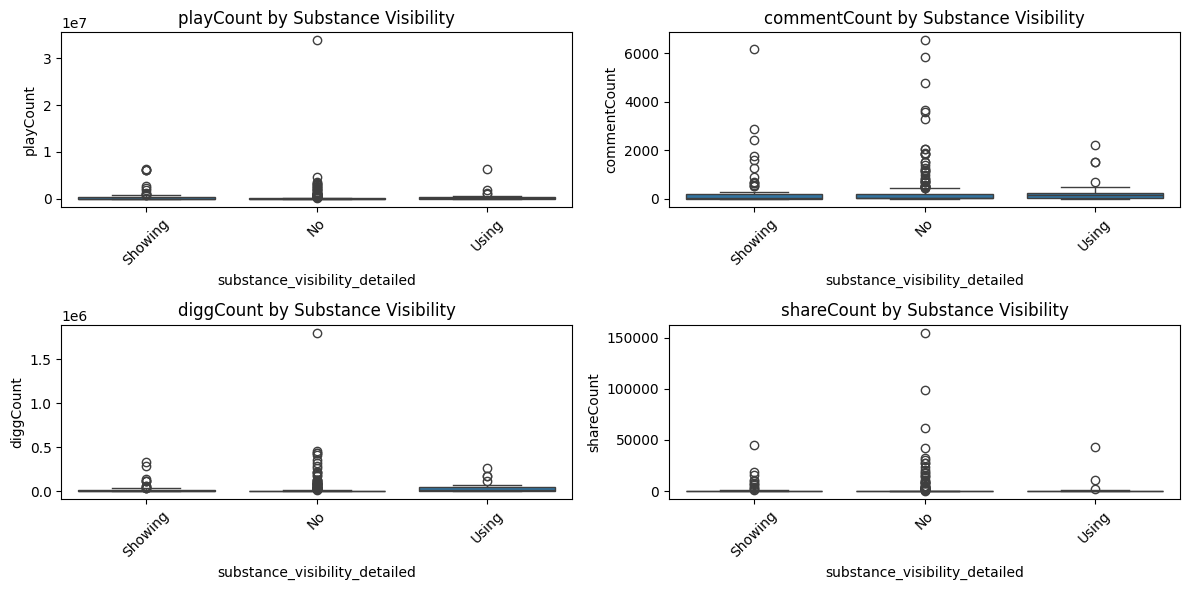

<Figure size 800x500 with 0 Axes>

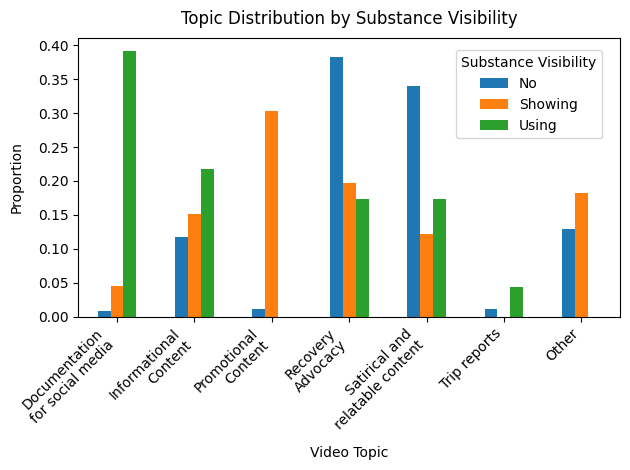


Statistical Test Results (Kruskal-Wallis):

playCount:
Statistic: 4.66
P-value: 0.0973

commentCount:
Statistic: 3.62
P-value: 0.1637

diggCount:
Statistic: 6.84
P-value: 0.0327

shareCount:
Statistic: 4.49
P-value: 0.1061

Mean Engagement Metrics by Group:
                                   playCount               commentCount  \
                                        mean           std         mean   
substance_visibility_detailed                                             
No                             386046.910156  2.206491e+06   293.464844   
Showing                        611112.787879  1.515417e+06   346.984848   
Using                          530538.565217  1.341118e+06   354.000000   

                                              diggCount                 \
                                      std          mean            std   
substance_visibility_detailed                                            
No                             794.368171  32341.191406  132573.6402

/var/folders/jj/bt0ykz9n5_16z2gvbybl0tbc0000gn/T/ipykernel_17222/2210064850.py:103: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = stats.mannwhitneyu(g1, g2, alternative='two-sided')


In [49]:
# Create two different grouping variables
# 1. Three-way comparison (Not Shown vs Showing vs Using)
coded['substance_visibility_detailed'] = coded['Are drugs/substance shown?']

# Function to perform Kruskal-Wallis test (for 3 groups)
def compare_engagement_three_way(df, metric):
    not_shown = df[df['substance_visibility_detailed'] == 'No'][metric]
    showing = df[df['substance_visibility_detailed'] == 'Showing'][metric]
    using = df[df['substance_visibility_detailed'] == 'Using'][metric]
    stat, pval = stats.kruskal(not_shown, showing, using)
    return stat, pval

# Calculate engagement metrics for three groups
engagement_metrics = ['playCount', 'commentCount', 'diggCount', 'shareCount']
engagement_comparison_detailed = coded.groupby('substance_visibility_detailed')[engagement_metrics].agg(['mean', 'std'])

# Perform statistical tests
stat_results_detailed = {}
for metric in engagement_metrics:
    stat, pval = compare_engagement_three_way(coded, metric)
    stat_results_detailed[metric] = {'statistic': stat, 'p-value': pval}

# Topic distribution for three groups
topic_dist_detailed = pd.crosstab(coded['Video Topic?'], 
                                 coded['substance_visibility_detailed'], 
                                 normalize='columns')

# Plotting
# 1. Engagement metrics comparison
plt.figure(figsize=(12, 6))
for i, metric in enumerate(engagement_metrics):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='substance_visibility_detailed', y=metric, data=coded)
    plt.title(f'{metric} by Substance Visibility')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

####################
# Create the plot with adjusted figure size
plt.figure(figsize=(8, 5))

# Plot the bars
# Plot based on 'Are drugs/substance shown?' column 
topic_dist = pd.crosstab(coded['Video Topic?'], 
                        coded['Are drugs/substance shown?'], 
                        normalize='columns')
# Move the "Other" group to the end
if 'Other' in topic_dist.index:
    reordered_index = [i for i in topic_dist.index if i != 'Other'] + ['Other']
    topic_dist = topic_dist.loc[reordered_index]

# Plot the reordered DataFrame
topic_dist.plot(kind='bar', stacked=False)

# Customize the plot
plt.title('Topic Distribution by Substance Visibility', pad=10)
plt.xlabel('Video Topic', labelpad=10)
plt.ylabel('Proportion', labelpad=10)

# Move legend inside the plot
plt.legend(title='Substance Visibility', 
          loc='upper right',  # Position in upper right corner
          bbox_to_anchor=(0.98, 0.98))  # Fine-tune position

# Rotate and align the tick labels so they look better
new_labels = ['Documentation\nfor social media', 
             'Informational\nContent',
             'Promotional\nContent',
             'Recovery\nAdvocacy',
             'Satirical and\nrelatable content',
             'Trip reports',
             'Other']  # 'Other' moved to the end
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig("../figures/visibility_by_topic.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Print statistical results
print("\nStatistical Test Results (Kruskal-Wallis):")
for metric, results in stat_results_detailed.items():
    print(f"\n{metric}:")
    print(f"Statistic: {results['statistic']:.2f}")
    print(f"P-value: {results['p-value']:.4f}")

# Print mean engagement metrics
print("\nMean Engagement Metrics by Group:")
print(engagement_comparison_detailed)

# Print topic distribution
print("\nTopic Distribution by Group:")
print(topic_dist_detailed)

# If significant differences are found, perform post-hoc pairwise tests
def pairwise_mannwhitney(df, metric):
    groups = ['Not shown', 'Showing', 'Using']
    results = []
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            g1 = df[df['substance_visibility_detailed'] == groups[i]][metric]
            g2 = df[df['substance_visibility_detailed'] == groups[j]][metric]
            stat, pval = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            results.append({
                'comparison': f'{groups[i]} vs {groups[j]}',
                'statistic': stat,
                'p-value': pval
            })
    return results

# Perform post-hoc tests for metrics with significant Kruskal-Wallis results
print("\nPost-hoc Pairwise Comparisons (Mann-Whitney U):")
for metric in engagement_metrics:
    if stat_results_detailed[metric]['p-value'] < 0.05:
        print(f"\n{metric}:")
        pairwise_results = pairwise_mannwhitney(coded, metric)
        for result in pairwise_results:
            print(f"{result['comparison']}:")
            print(f"Statistic: {result['statistic']:.2f}")
            print(f"P-value: {result['p-value']:.4f}")

---
# Key Hashtag Analysis

In [23]:
from collections import Counter
coded['hashtags'] = coded['hashtags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize a dictionary to store top hashtags per topic
top_hashtags_per_topic = {}

# Group dataset by topic and process hashtags
for topic, group in coded.groupby('Video Topic?'):
    # Flatten the list of hashtags for the current topic
    hashtags = [hashtag for hashtags in group['hashtags'] if hashtags for hashtag in hashtags]
    
    # Count hashtag frequencies
    hashtag_counts = Counter(hashtags)
    
    # Get the top 5 hashtags for this topic
    top_hashtags = hashtag_counts.most_common(5)
    
    # Store the results
    top_hashtags_per_topic[topic] = top_hashtags

# Display the top hashtags per topic
print("Top 5 Hashtags Per Topic:")
for topic, hashtags in top_hashtags_per_topic.items():
    print(f"\nTopic: {topic}")
    for hashtag, count in hashtags:
        print(f"  #{hashtag}: {count}")

Top 5 Hashtags Per Topic:

Topic: Documentation of use for social media
  #fyp: 8
  #drunk: 7
  #tasty: 6
  #cheers: 6
  #downthehatch: 6

Topic: Informational Content
  #harmreduction: 16
  #: 12
  #fyp: 11
  #sober: 10
  #harmreductionsaveslives: 9

Topic: Other
  #fyp: 15
  #recovery: 10
  #addiction: 8
  #viral: 7
  #trippy: 7

Topic: Promotional Content
  #vape: 11
  #fyp: 11
  #vaping: 8
  #nootropics: 7
  #focus: 6

Topic: Recovery Advocacy
  #recovery: 66
  #addiction: 53
  #sober: 44
  #harmreduction: 37
  #sobriety: 37

Topic: Satirical and relatable content
  #fyp: 56
  #addiction: 26
  #funny: 26
  #viral: 24
  #recovery: 23

Topic: Trip Reports
  #drunk: 1
  #drunkbestfriend: 1
  #blackout: 1
  #wasted: 1
  #vacation: 1


In [24]:
# key_hashtags = ['recovery', 'addiction', 'sober', 'harmreduction', 'addictionrecovery']
# key_hashtags = ['recovery', 'addiction', 'drunk', 'harmreduction', 'trippy', 'vape','sober', 
                # 'addictionrecovery','harmreductionsaveslives', 'pain', 'chronicpain']
key_hashtags = ['recovery', 'addiction', 'harmreduction','harmreductionsaveslives','narcan', 'wedorecover', 'chronicpain',
                'addictionhumor', 'pingtok']

In [25]:
# hashtag use over time
coded['upload_time'] = pd.to_datetime(coded['createTime'], unit='s', errors='coerce')

# Check for invalid dates
invalid_dates = coded['upload_time'].isna().sum()
if invalid_dates > 0:
    print(f"Number of invalid dates: {invalid_dates}")
    coded = coded.dropna(subset=['upload_time'])

# Ensure dates are within a reasonable range (e.g., no future dates)
# Replace '1970-01-01' and '2025-01-01' with your expected date range
date_range_start = '1970-01-01'
date_range_end = '2025-01-01'
coded = coded[(coded['upload_time'] >= date_range_start) & (coded['upload_time'] <= date_range_end)]
coded['upload_time'].isna().sum()

Number of invalid dates: 6


np.int64(0)

In [26]:
top_hashtag_data = coded[coded['hashtags'].apply(lambda x: any(h in key_hashtags for h in (x or [])))]

# Expand the hashtags column for easier grouping
top_hashtag_data = top_hashtag_data.explode('hashtags')

# Filter only for top hashtags
top_hashtag_data = top_hashtag_data[top_hashtag_data['hashtags'].isin(key_hashtags)]

# Group by date and hashtag
top_hashtag_data['upload_date'] = top_hashtag_data['upload_time'].dt.date
temporal_counts = top_hashtag_data.groupby(['upload_date', 'hashtags']).size().reset_index(name='count')

# Plot temporal trends
# plt.figure(figsize=(12, 6))
# for hashtag in key_hashtags:
#     hashtag_data = temporal_counts[temporal_counts['hashtags'] == hashtag]
#     plt.plot(hashtag_data['upload_date'], hashtag_data['count'], label=f'#{hashtag}')

# plt.title('Temporal Trends for Top Hashtag per Content Topic')
# plt.xlabel('Date')
# plt.ylabel('Frequency')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

/var/folders/jj/bt0ykz9n5_16z2gvbybl0tbc0000gn/T/ipykernel_17222/565009401.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = hashtag_data['count'].resample('M').sum()  # Monthly sum


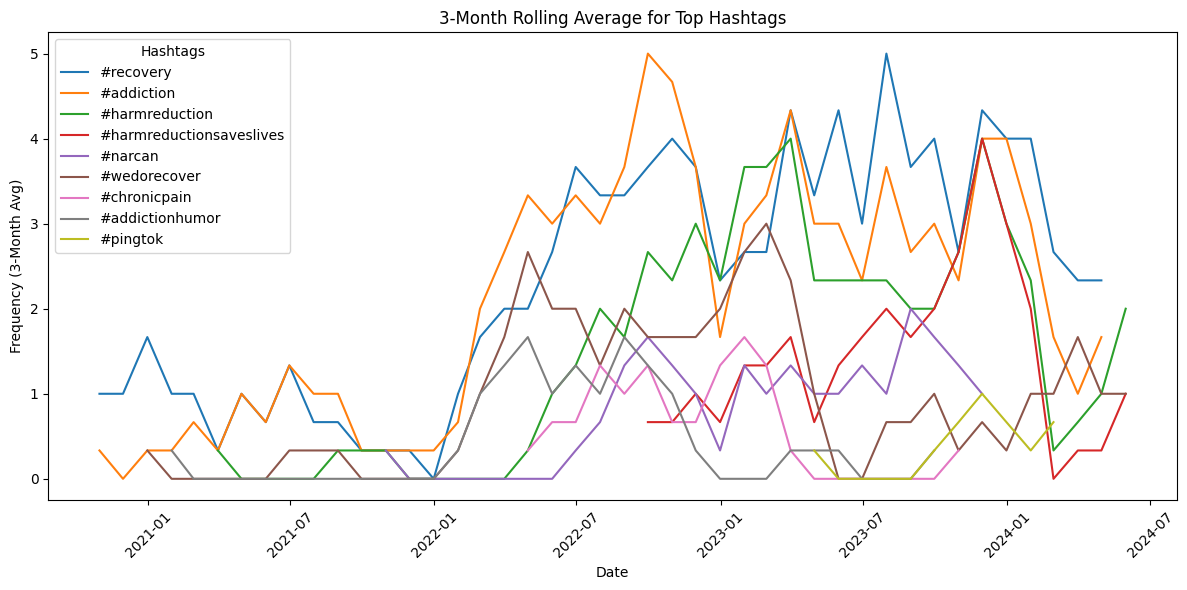

In [27]:
# Resample by month and calculate 3-month rolling average for each hashtag
# Ensure 'upload_date' is a datetime type
temporal_counts['upload_date'] = pd.to_datetime(temporal_counts['upload_date'])

# Set 'upload_date' as the index for easier resampling
temporal_counts.set_index('upload_date', inplace=True)

rolling_averages = []
for hashtag in key_hashtags:
    hashtag_data = temporal_counts[temporal_counts['hashtags'] == hashtag]
    monthly_counts = hashtag_data['count'].resample('M').sum()  # Monthly sum
    rolling_avg = monthly_counts.rolling(window=3).mean()       # 3-month rolling average
    rolling_averages.append((hashtag, rolling_avg))

# Plot the 3-month rolling averages
plt.figure(figsize=(12, 6))
for hashtag, rolling_avg in rolling_averages:
    plt.plot(rolling_avg.index, rolling_avg, label=f'#{hashtag}')

# Customize the plot
plt.title('3-Month Rolling Average for Top Hashtags')
plt.xlabel('Date')
plt.ylabel('Frequency (3-Month Avg)')
plt.legend(title='Hashtags', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

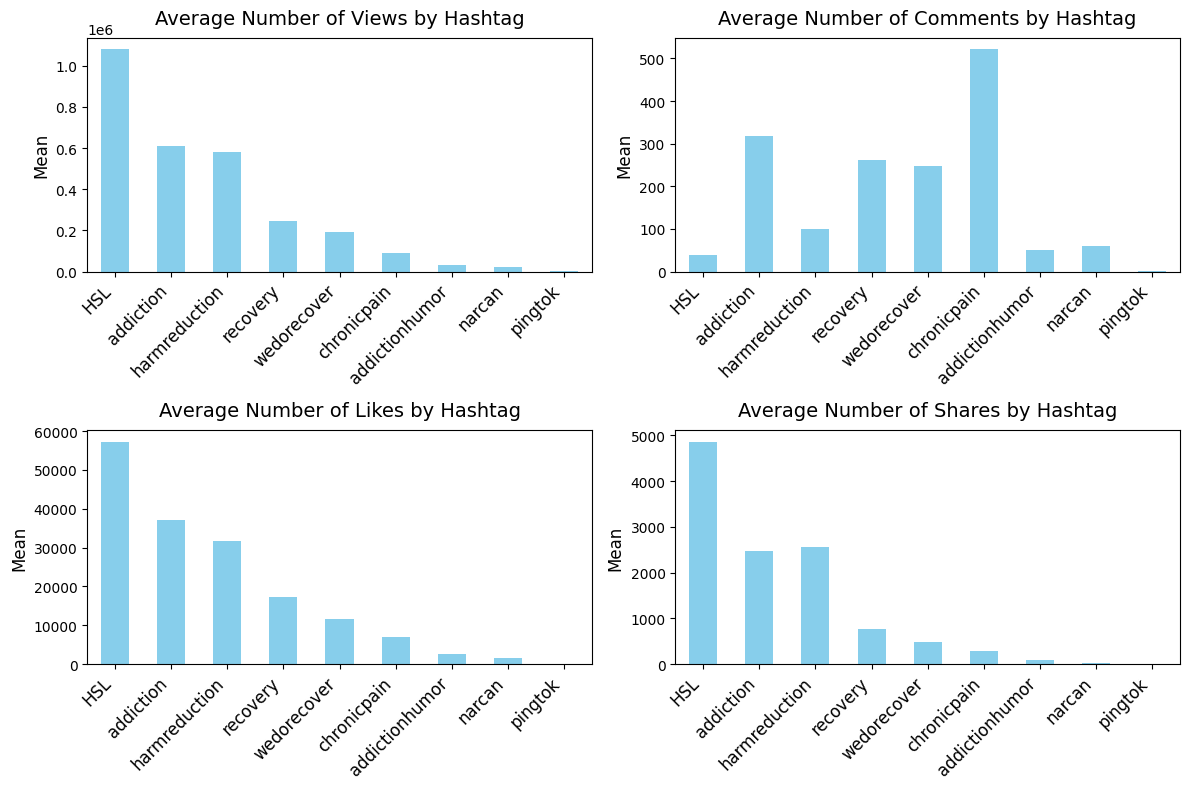

In [50]:
# Select relevant columns (replace these with your actual engagement metric column names)
engagement_metrics = ['playCount', 'commentCount', 'diggCount', 'shareCount']

# Filter for rows with key hashtags
hashtag_data = coded.explode('hashtags')  # Ensure one hashtag per row if stored as lists
hashtag_data = hashtag_data[hashtag_data['hashtags'].isin(key_hashtags)]

# Group by hashtags and calculate metrics
engagement_summary = hashtag_data.groupby('hashtags')[engagement_metrics].agg(['mean', 'median', 'std'])

# Flatten the MultiIndex for better readability
engagement_summary.columns = ['_'.join(col).strip() for col in engagement_summary.columns]

# Sort by highest average playCount (optional)
engagement_summary = engagement_summary.sort_values(by='playCount_mean', ascending=False)

# Display the summary
# import ace_tools as tools; tools.display_dataframe_to_user(name="Engagement Metrics by Hashtag", dataframe=engagement_summary)

# plt.figure(figsize=(12, 8))
# for i, metric in enumerate(engagement_metrics):
#     plt.subplot(2, 2, i + 1)
#     engagement_summary[f'{metric}_mean'].plot(kind='bar', title=f'Average {metric} by Hashtag', color='skyblue')
#     plt.ylabel('Mean')
#     plt.xlabel('Hashtag')
#     plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

metric_titles = {
    'diggCount': 'Number of Likes',
    'playCount': 'Number of Views',
    'shareCount': 'Number of Shares',
    'commentCount': 'Number of Comments'
}

plt.figure(figsize=(12, 8))
for i, metric in enumerate(engagement_metrics):
    plt.subplot(2, 2, i + 1)
    
    # Plot the bar chart
    ax = engagement_summary[f'{metric}_mean'].plot(kind='bar', color='skyblue')
    
    # Customize the title using the mapping
    ax.set_title(f'Average {metric_titles[metric]} by Hashtag', fontsize=14, pad=10)
    
    # Remove the x-axis label
    ax.set_xlabel('')
    
     # Create custom x-axis labels
    custom_labels = [
        'HSL' if label == 'harmreductionsaveslives' else label 
        for label in engagement_summary.index
    ]

    # Explicitly set tick positions and labels with bigger, bolder font
    ax.set_xticks(range(len(custom_labels)))  # Tick positions
    ax.set_xticklabels(
        custom_labels, 
        rotation=45, 
        ha='right', 
        fontsize=12,  # Increase font size
        # fontweight='bold'  # Make font bold
    )
    
    # Add y-axis label
    ax.set_ylabel('Mean', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("../figures/engagement_hashtags.pdf", format="pdf", bbox_inches="tight")
plt.show()